In [2]:
import torch

# DetoxAI
import detoxai
from detoxai import CorrectionResult
from detoxai.visualization import ScatterVisualizer, SSVisualizer

device = "cpu"
print(f"Using DetoxAI version: {detoxai.__version__}")

Using DetoxAI version: 0.3.7


In [3]:
def get_your_dataset() -> torch.utils.data.Dataset:
    from detoxai.utils.datasets import get_detoxai_datasets, DetoxaiDataset
    from detoxai.utils.transformations import SquarePad
    from detoxai import download_datasets
    import torchvision

    download_datasets(["celeba"])

    CELEBA_DATASET_CONFIG = {
        "name": "celeba",
        "target": "Smiling",  # target attribute that should be predicted
        # Note that celeba has quite a lot of examples, so to make things easier,
        # we will use a smaller subset of the dataset
        "splits": {"train": 0.003, "test": 0.01, "unlearn": 0.003, "no": 0.984},
    }

    datasets: list[DetoxaiDataset] = get_detoxai_datasets(
        CELEBA_DATASET_CONFIG,
        transform=torchvision.transforms.Compose(
            [SquarePad(), torchvision.transforms.ToTensor()]
        ),
        device=device,
    )

    return datasets

In [4]:
def get_your_dataloaders(
    dataset,
) -> tuple[
    torch.utils.data.DataLoader,
    torch.utils.data.DataLoader,
    torch.utils.data.DataLoader,
]:
    from detoxai.utils.dataloader import DetoxaiDataLoader

    pa = "Wearing_Hat"  # protected attribute
    pa_value = 1  # protected attribute value

    collate_fn = dataset["train"].get_collate_fn(pa, pa_value)

    dataloader_train = DetoxaiDataLoader(
        dataset["train"], collate_fn=collate_fn, batch_size=256
    )
    dataloader_unlearn = DetoxaiDataLoader(
        dataset["unlearn"], collate_fn=collate_fn, batch_size=128
    )
    dataloader_test = DetoxaiDataLoader(
        dataset["test"], collate_fn=collate_fn, batch_size=256
    )
    return dataloader_train, dataloader_test, dataloader_unlearn

In [5]:
def train_your_vanilla_model(dl_train) -> torch.nn.Module:
    import lightning as L
    import torchvision
    from detoxai.core.model_wrappers import FairnessLightningWrapper

    L.seed_everything(123, workers=True)

    model = torchvision.models.resnet18(
        weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
    )
    model.fc = torch.nn.Linear(model.fc.in_features, 2)  # Make it binary classification
    model = model.to(device)
    trainer = L.Trainer(
        logger=False,
        max_epochs=3,
        devices=[int(str(device).split(":")[1])] if str(device) != "cpu" else 1,
        accelerator="gpu" if "cuda" in device else "cpu",
        enable_checkpointing=False,
    )
    trainer.fit(FairnessLightningWrapper(model), dl_train)

    return model

### Get your dataset and set up dataloaders 

In [6]:
dataset = get_your_dataset()
dl_train, dl_test, dl_unlearn = get_your_dataloaders(dataset)

### Check the output format

In [7]:
img, label, pa = next(iter(dl_train))
print(f"Img: {img.shape}, Label: {label.shape}, pa: {pa.shape}")

Img: torch.Size([256, 3, 218, 218]), Label: torch.Size([256]), pa: torch.Size([256])


### Get your vanilla model, which you will later debias

In [8]:
model = train_your_vanilla_model(dl_train)

INFO: Seed set to 123
INFO:lightning.fabric.utilities.seed:Seed set to 123
/home/inf148179/detoxai/detoxai/.venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/inf148179/detoxai/detoxai/.venv/lib/python3.11 ...
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/inf148179/detoxai/detoxai/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing.

Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s] 

/home/inf148179/detoxai/detoxai/.venv/lib/python3.11/site-packages/lightning/pytorch/core/module.py:758: `training_step` must be implemented to be used with the Lightning Trainer


Epoch 2: 100%|██████████| 3/3 [00:08<00:00,  0.34it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 3/3 [00:08<00:00,  0.34it/s]


### (optional) Visualize saliency maps for qualitative inspection

#### Aggregated maps

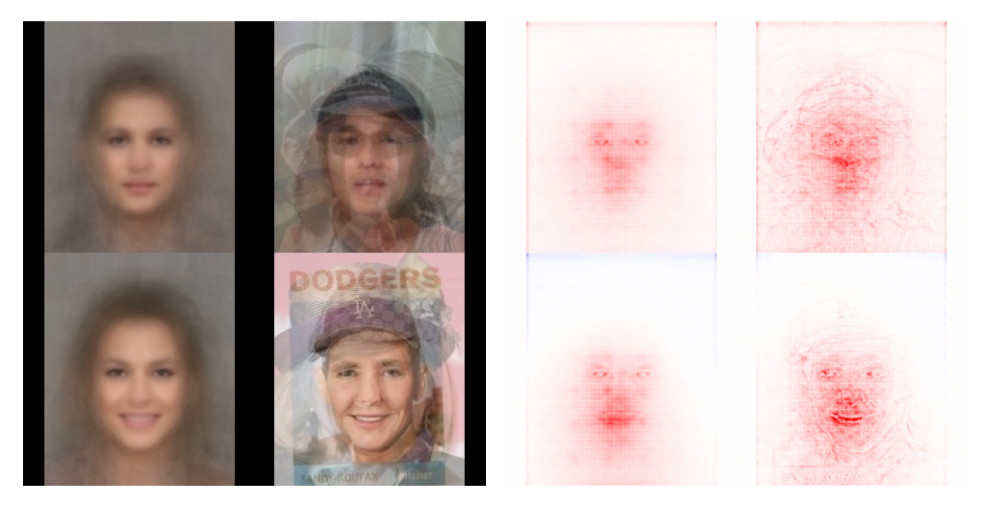

In [9]:
visualizer = SSVisualizer(dl_train, model)
visualizer.visualize_agg(0)

#### Per-image maps

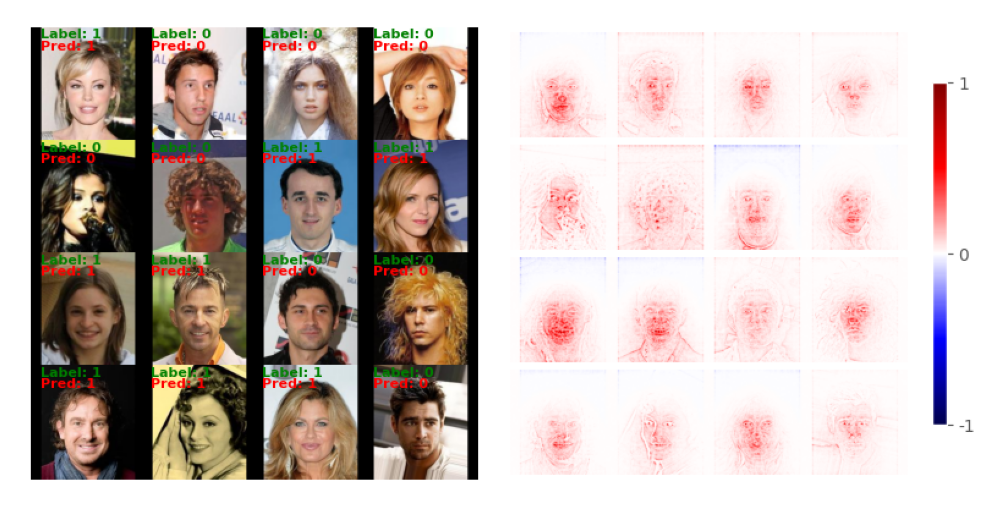

In [10]:
visualizer.visualize_batch(batch_num=0, max_images=16)

<div style="background-color: #FF6600">
    <h3 style="color: #FFFFFF; font-weight: bold; text-align: center"> Debiasing with DetoxAI </h3>
</div>

### Let's see the supported methods

In [11]:
supported_methods = detoxai.get_supported_methods()
print(f"Supported methods: {supported_methods}")
print(f"Count: {len(supported_methods)}")

Supported methods: ['SAVANIRP', 'SAVANILWO', 'SAVANIAFT', 'ZHANGM', 'RRCLARC', 'PCLARC', 'ACLARC', 'LEACE', 'NT', 'FINETUNE']
Count: 10


### Finally, use the `.debias` api 

In [12]:
selected = [
    "RRCLARC",
    "ACLARC",
    "LEACE",
    "ZHANGM",
    "SAVANIAFT",
    "NT",
]

# this will run all the debiasing methods,
# you can pass which ones you want to run by passing methods=["RRCLARC", "SAVANIAFT", ...]
results: dict[str, CorrectionResult] = detoxai.debias(
    model,
    dl_unlearn,
    test_dataloader=dl_test,  # This is optional, but we can use it to evaluate the model and have metrics in the results
    methods=selected,  # Here, we run only a select few methods
    return_type="all",  # this will return all the results, you can also use "pareto-front" or "best"
)

/home/inf148179/detoxai/detoxai/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/inf148179/detoxai/detoxai/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
/home/inf148179/detoxai/detoxai/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'performance_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['performance_metrics'])`.
/home/inf148179/detoxai/detoxai/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsi

Extracting Activations: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]

/home/inf148179/detoxai/detoxai/.venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/inf148179/detoxai/detoxai/.venv/lib/python3.11 ...
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


/home/inf148179/detoxai/detoxai/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:44: Attribute 'model' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['model'])`.
/home/inf148179/detoxai/detoxai/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.
INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU ava

In [13]:
results

{'RRCLARC': Results for: RRCLARC,
 'ACLARC': Results for: ACLARC,
 'LEACE': Results for: LEACE,
 'ZHANGM': Results for: ZHANGM,
 'SAVANIAFT': Results for: SAVANIAFT,
 'NT': Results for: NT,
 'Vanilla': Results for: Vanilla}

In [14]:
debiased_model = results["SAVANIAFT"].get_model()

### Visualize saliency mpas for one of the debiased models

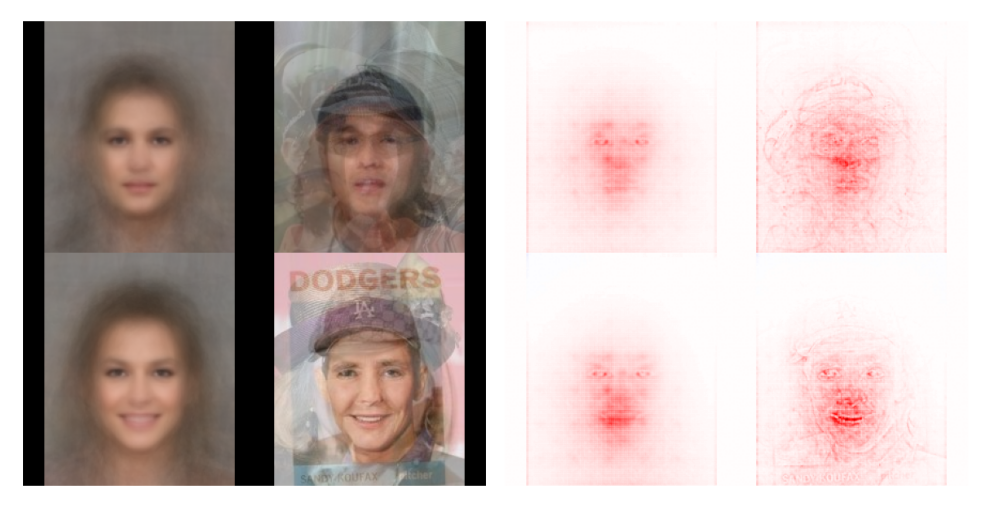

In [15]:
visualizer2 = SSVisualizer(dl_train, debiased_model)
visualizer2.visualize_agg(0)

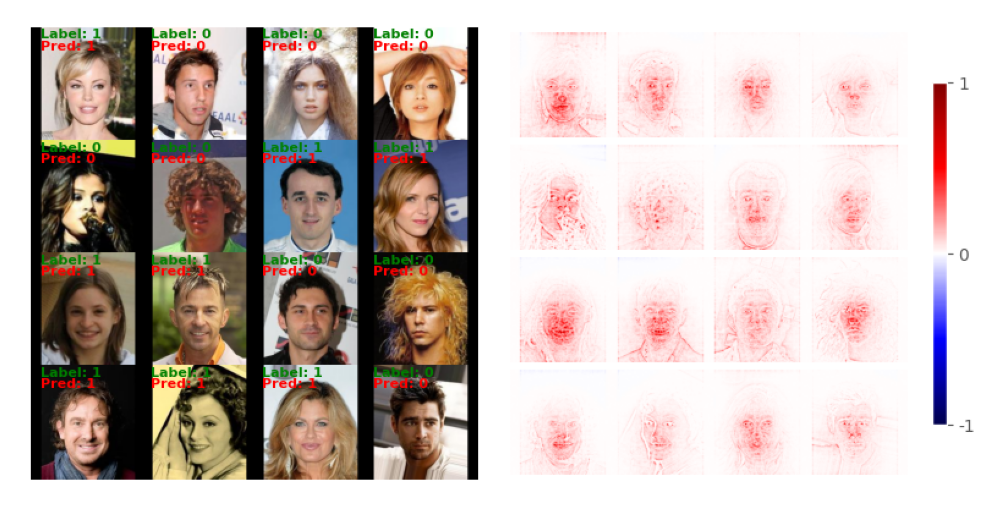

In [16]:
visualizer2.visualize_batch(batch_num=0, max_images=16)

### Generate a scatterplot for qualitative analysis

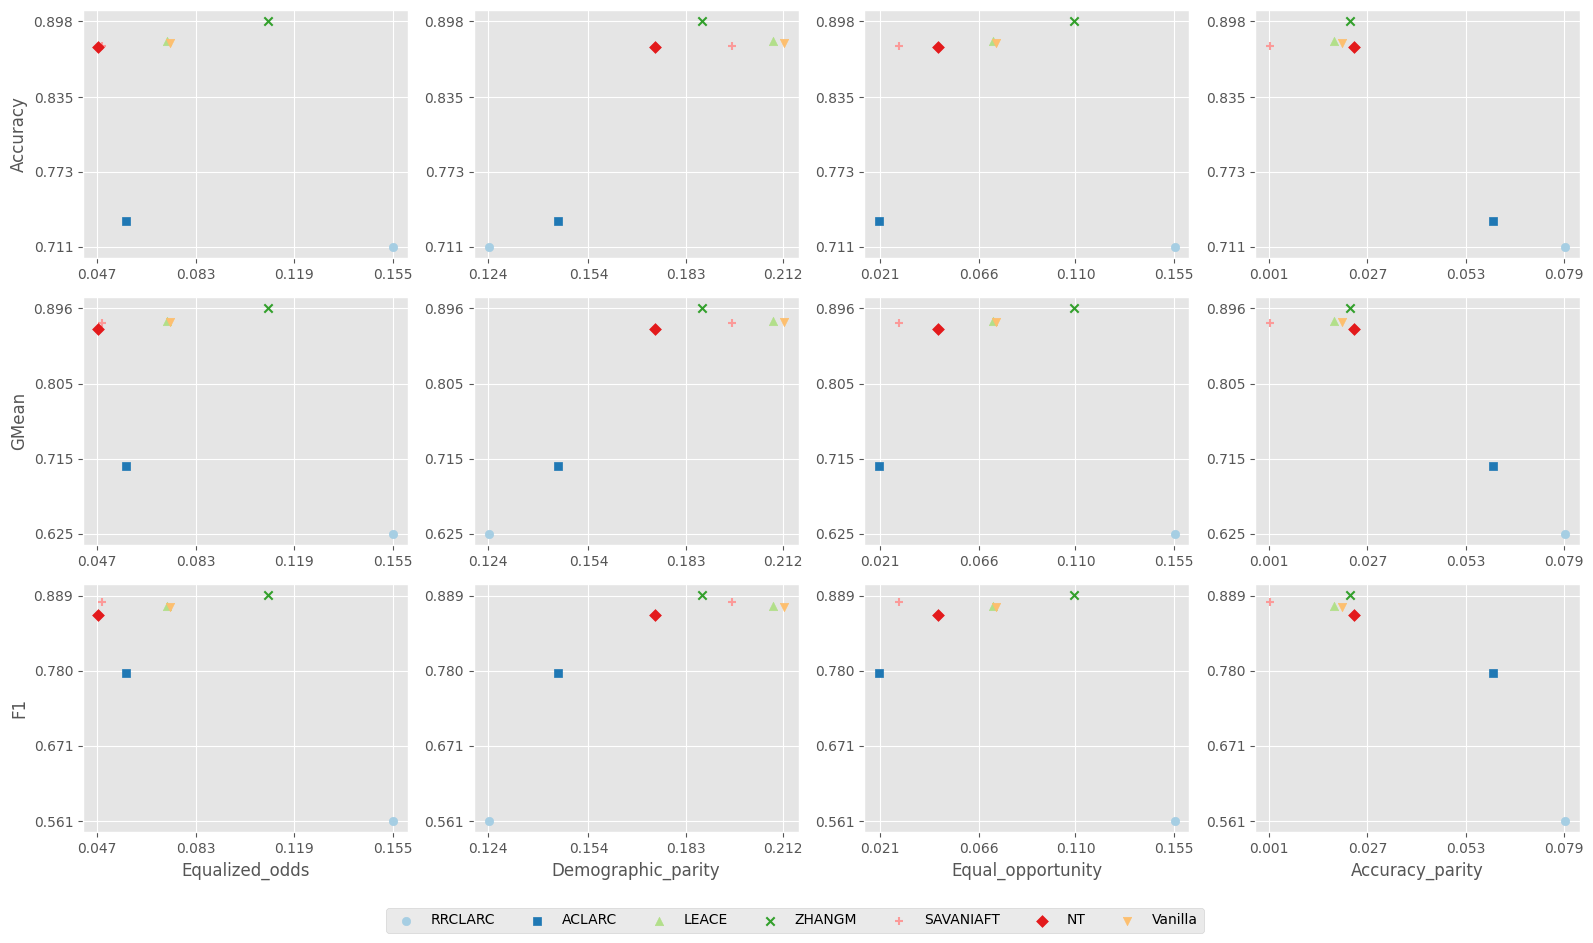

In [17]:
scatter_vis = ScatterVisualizer()
scatter_vis.create_plot(results)